<a href="https://colab.research.google.com/github/adv555/DataScience/blob/main/Keras/Oil_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Enviroment preparing

In [ ]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.1/589.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 KB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Fo

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
print(tf.__version__)

2.11.0


# LSTM model

### Data downloading

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DCOILBRENTEU.xls to DCOILBRENTEU.xls


In [ ]:
data = pd.read_excel('DCOILBRENTEU.xls')
data = data[10:]
data.head()

,FRED Graph Observations,Unnamed: 1
10,2013-02-13 00:00:00,118.43
11,2013-02-14 00:00:00,118.48
12,2013-02-15 00:00:00,117.4
13,2013-02-18 00:00:00,0
14,2013-02-19 00:00:00,117.04


In [ ]:
prices = data.iloc[:,1:2].values
dates = data.iloc[:,0:1].values

data_oil = pd.DataFrame(prices, columns=['prices'])
data_oil['Date'] = dates
data_oil = data_oil.set_index('Date')
data_oil.head()

,prices
Date,
2013-02-13,118.43
2013-02-14,118.48
2013-02-15,117.4
2013-02-18,0
2013-02-19,117.04


In [ ]:
type(dates)

numpy.ndarray

In [ ]:
data_oil.shape

(2542, 1)

### Visualization of explore data

Cleaning data 

In [ ]:
data_oil = data_oil[(data_oil['prices'] != 0)]
data_oil.shape

(2542, 1)

In [ ]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", color = 'red', start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, color = color, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)


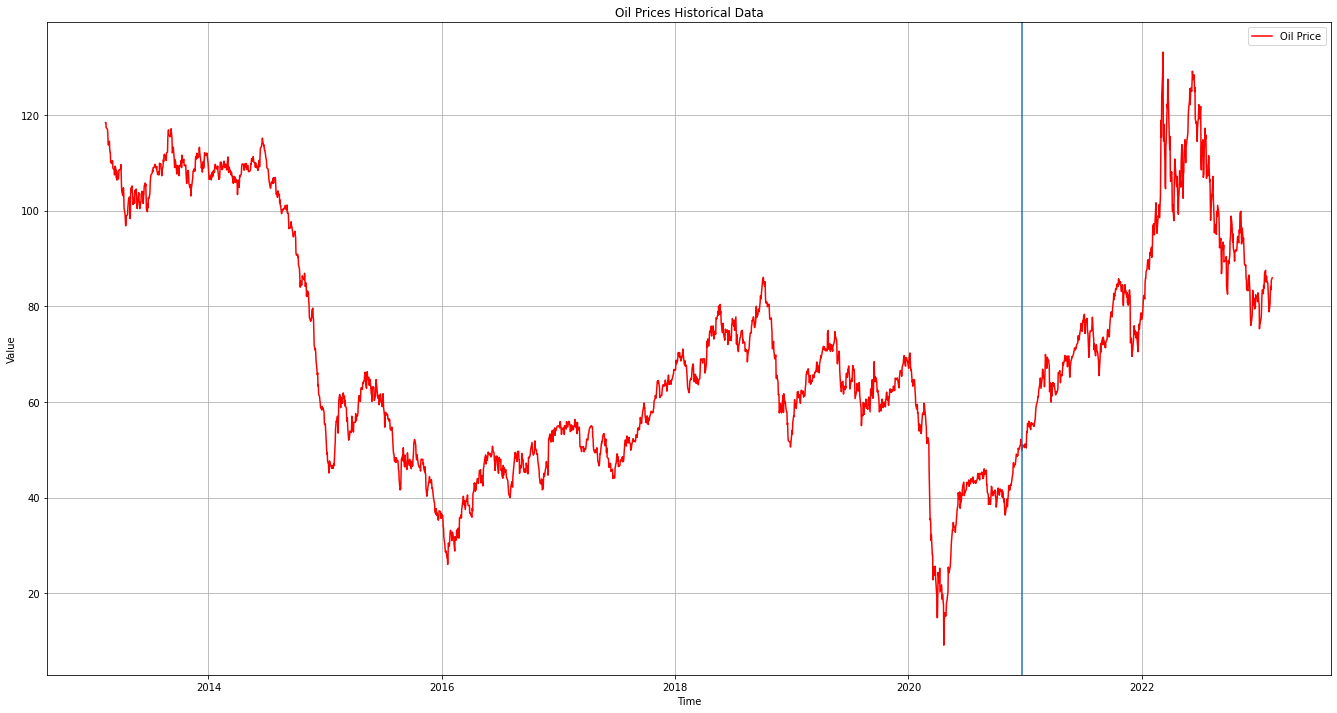

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Historical Data')
plot_series(data_oil.index, data_oil.prices, label = 'Oil Price')
plt.axvline(x=data_oil.index[2000])

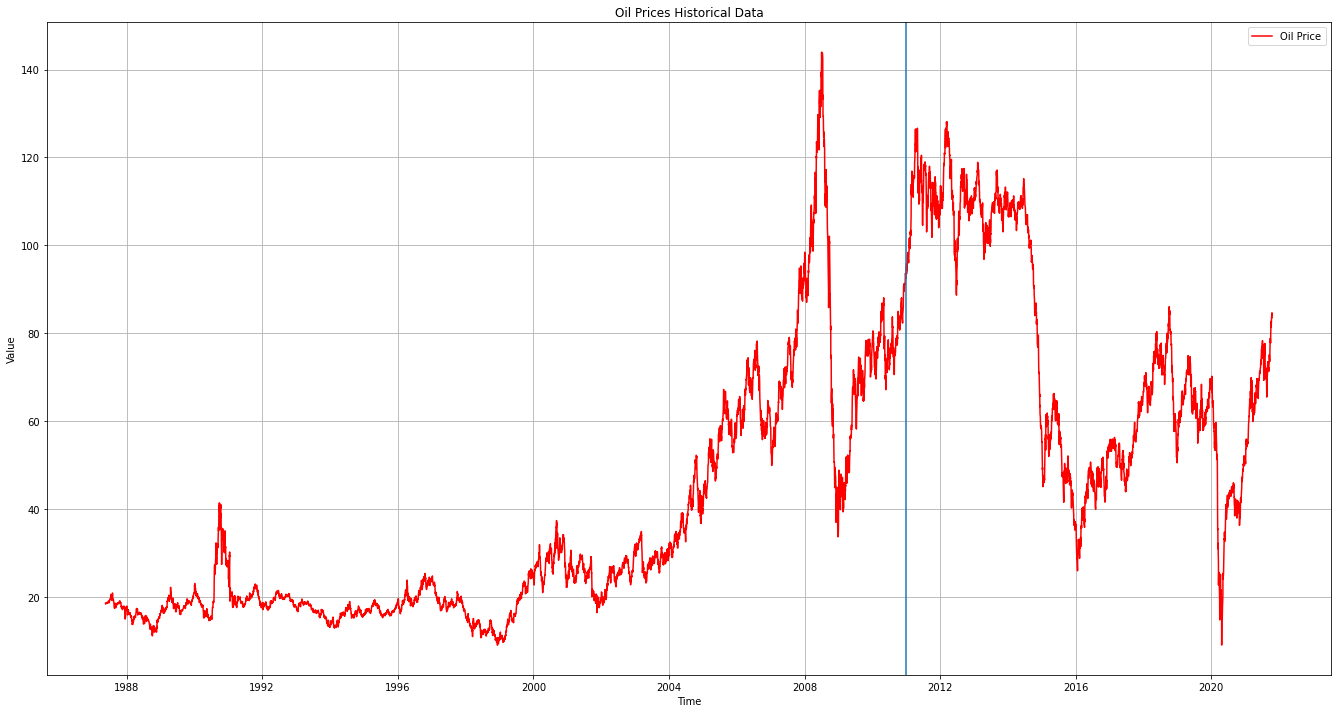

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Historical Data')
plot_series(data_oil.index, data_oil.prices, label = 'Oil Price')
plt.axvline(x=data_oil.index[6000])

In [ ]:
data_oil.index

DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-18'],
              dtype='datetime64[ns]', name='Date', length=8737, freq=None)

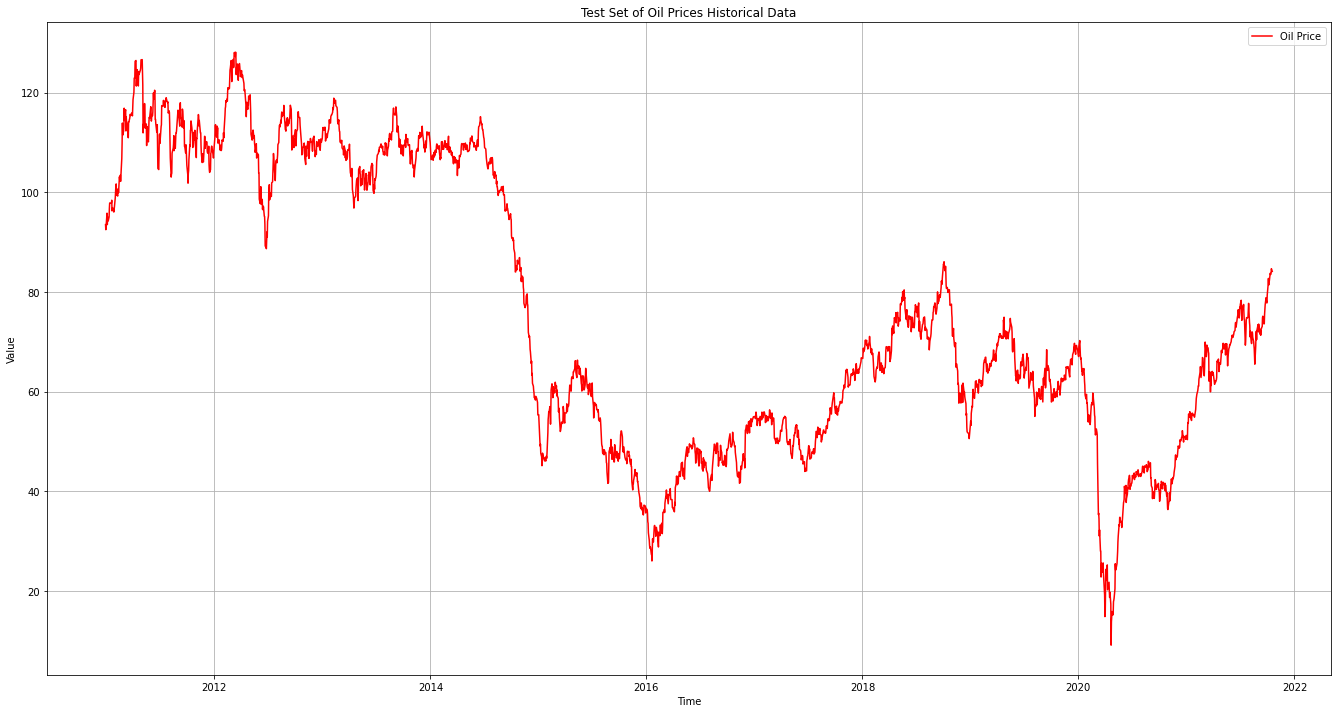

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Test Set of Oil Prices Historical Data')
plot_series(data_oil.index[6000:], data_oil.prices[6000:], label = 'Oil Price')

### Dataset preparing

Задамо гіперпараметри

In [ ]:
batch_size = 32
timesteps = 20
test_size = 6000

In [ ]:
explore_data = data_oil.iloc[:,0:1].values


Знайдемо довжину навчальних даних, щоб вона була кратною batch size

In [ ]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
#             print(x)
    return (max(train_length_values))

In [ ]:
length = get_train_length(explore_data, batch_size, test_size)
print(length)

5984


In [ ]:
upper_train = length + timesteps*2

training_set = explore_data[:upper_train]
training_set.shape

(6024, 1)

### Data normalization

Нормуємо наші дані, щоб вони були в межах від 0 до 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(6024, 1)

Сформуємо дані й лейбли для навчання нейронної мережі

In [ ]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])
    
print(training_set_scaled[20:40])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

6004
[[0.07378569]
 [0.07378569]
 [0.07415647]
 [0.07267334]
 [0.07156099]
 [0.07119021]
 [0.07400816]
 [0.07452725]
 [0.07400816]
 [0.07326659]
 [0.07526882]
 [0.07586207]
 [0.07697442]
 [0.07712273]
 [0.07697442]
 [0.07845755]
 [0.07882833]
 [0.07956989]
 [0.07994067]
 [0.08290693]]
5984
5984
[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099,
       0.07178346, 0.07081943, 0.07156099, 0.07178346, 0.07178346,
       0.0710419 , 0.07178346, 0.07267334, 0.07363737, 0.07378569])]
(5984, 20)
[array([0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659,
       0.07526882

Підготуємо їх до формату, який потрібен для нейронної мережі

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(5984, 20, 1)
(5984, 20, 1)


### Creating of neural network model

Побудуємо нашу модель і виведемо інформацію про неї

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(batch_shape=(batch_size, timesteps, 1)),
    tf.keras.layers.LSTM(10, stateful=True, return_sequences=True),
    tf.keras.layers.LSTM(10, stateful=True, return_sequences=True),
    tf.keras.layers.Dense(units = 1)
])
model.compile(loss='mae',optimizer='adam',metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 20, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (32, 20, 10)              840       
_________________________________________________________________
dense (Dense)                (32, 20, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


### Training

Натренуємо модель на навчальному датасеті взявши 150 епох

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size = batch_size, shuffle = False, verbose=2)

Epoch 1/150
187/187 - 9s - loss: 0.0435 - mse: 0.0053
Epoch 2/150
187/187 - 2s - loss: 0.0388 - mse: 0.0041
Epoch 3/150
187/187 - 2s - loss: 0.0379 - mse: 0.0038
Epoch 4/150
187/187 - 2s - loss: 0.0355 - mse: 0.0035
Epoch 5/150
187/187 - 2s - loss: 0.0338 - mse: 0.0032
Epoch 6/150
187/187 - 2s - loss: 0.0327 - mse: 0.0030
Epoch 7/150
187/187 - 2s - loss: 0.0318 - mse: 0.0028
Epoch 8/150
187/187 - 2s - loss: 0.0310 - mse: 0.0027
Epoch 9/150
187/187 - 2s - loss: 0.0304 - mse: 0.0026
Epoch 10/150
187/187 - 2s - loss: 0.0298 - mse: 0.0025
Epoch 11/150
187/187 - 2s - loss: 0.0294 - mse: 0.0024
Epoch 12/150
187/187 - 2s - loss: 0.0290 - mse: 0.0023
Epoch 13/150
187/187 - 2s - loss: 0.0286 - mse: 0.0023
Epoch 14/150
187/187 - 2s - loss: 0.0284 - mse: 0.0023
Epoch 15/150
187/187 - 2s - loss: 0.0279 - mse: 0.0022
Epoch 16/150
187/187 - 2s - loss: 0.0276 - mse: 0.0021
Epoch 17/150
187/187 - 2s - loss: 0.0275 - mse: 0.0021
Epoch 18/150
187/187 - 2s - loss: 0.0272 - mse: 0.0021
Epoch 19/150
187/18

Зобразимо графік loss-функції, щоб переконатись, що наша модель добре тренувалась, і ми підібрали вдалу к-сть епох

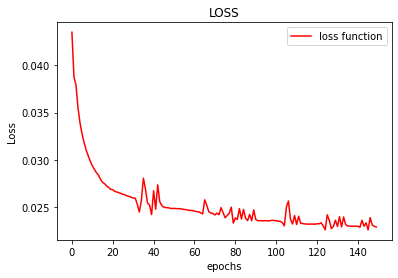

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'loss function')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('Loss')
# plt.xticks([data.index[upper_train], data.index[upper_train+75], data.index[upper_train+150], data.index[upper_train+225]])
plt.legend()
plt.show()

Також побудуємо графік зміни середнього квадратичного відхилення від к-сті епох

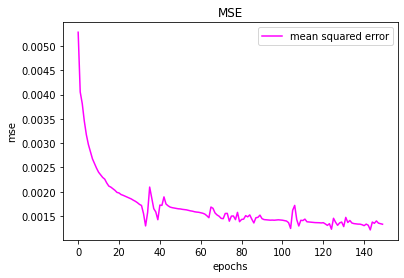

In [ ]:
plt.plot(history.history['mse'], color = 'magenta', label = 'mean squared error')
plt.title('MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

### Prepare testset

Знайдемо його довжину

In [ ]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))
  
test_length = get_test_length(explore_data, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

8552
8584
8616
8648
8680
8680
2656


In [ ]:
print(upper_train, upper_test, len(explore_data))

6024 8720 8737


Нормалізуємо і зробимо такого ж формату, як і трейнсет (тренувальний датасет)

In [ ]:
#subsetting
test_set = explore_data[upper_train:upper_test] 

#scaling
scaled_real_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
test_set.shape

(2696, 1)

In [ ]:
X_test.shape

(2656, 20, 1)

### Model prediction

Застосуємо натреновану нейронну мережу, для знаходження прогнозованої ціни

In [ ]:
predicted_test = model.predict(X_test, batch_size=batch_size)

In [ ]:
predicted_test.shape

(2656, 20, 1)

Переведемо спрогнозовані значення у звичний вигляд

In [ ]:
y_test = []
for j in range(0, testset_length):
    y_test = np.append(y_test, predicted_test[j, timesteps-1])

# reshaping#reshaping
predicted_test = np.reshape(predicted_test, 
                           (predicted_test.shape[0], 
                            predicted_test.shape[1]))

print(predicted_test.shape)
#inverse transform
predicted_test = sc.inverse_transform(predicted_test)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_test[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

(2656, 20)
(2636, 1)


### Results Vizualization

Зобразимо результат на графіку

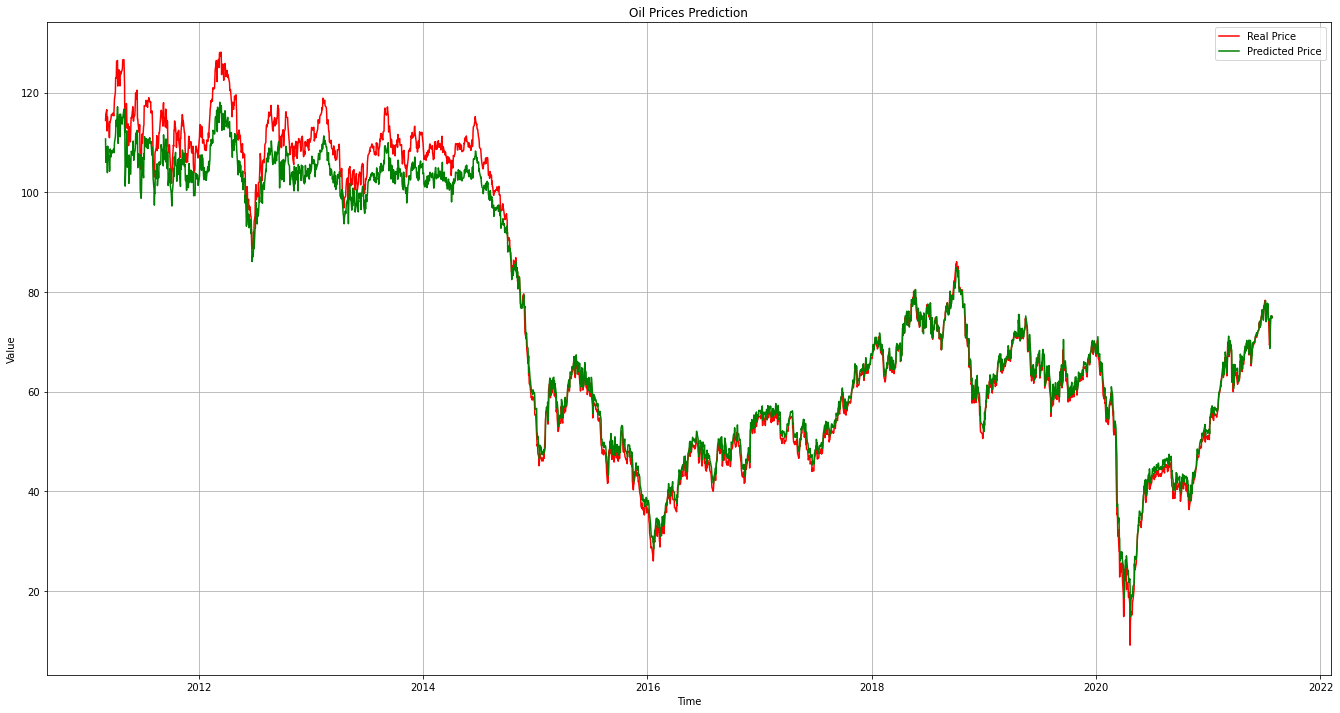

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Prediction')
plot_series(data_oil.index, data_oil.prices, start = upper_train+timesteps, end = upper_train+timesteps+len(y_test), label = 'Real Price')
plot_series(data_oil.index[upper_train+timesteps:upper_train+timesteps+len(y_test)], y_test.astype(float), color = 'green', label = 'Predicted Price')

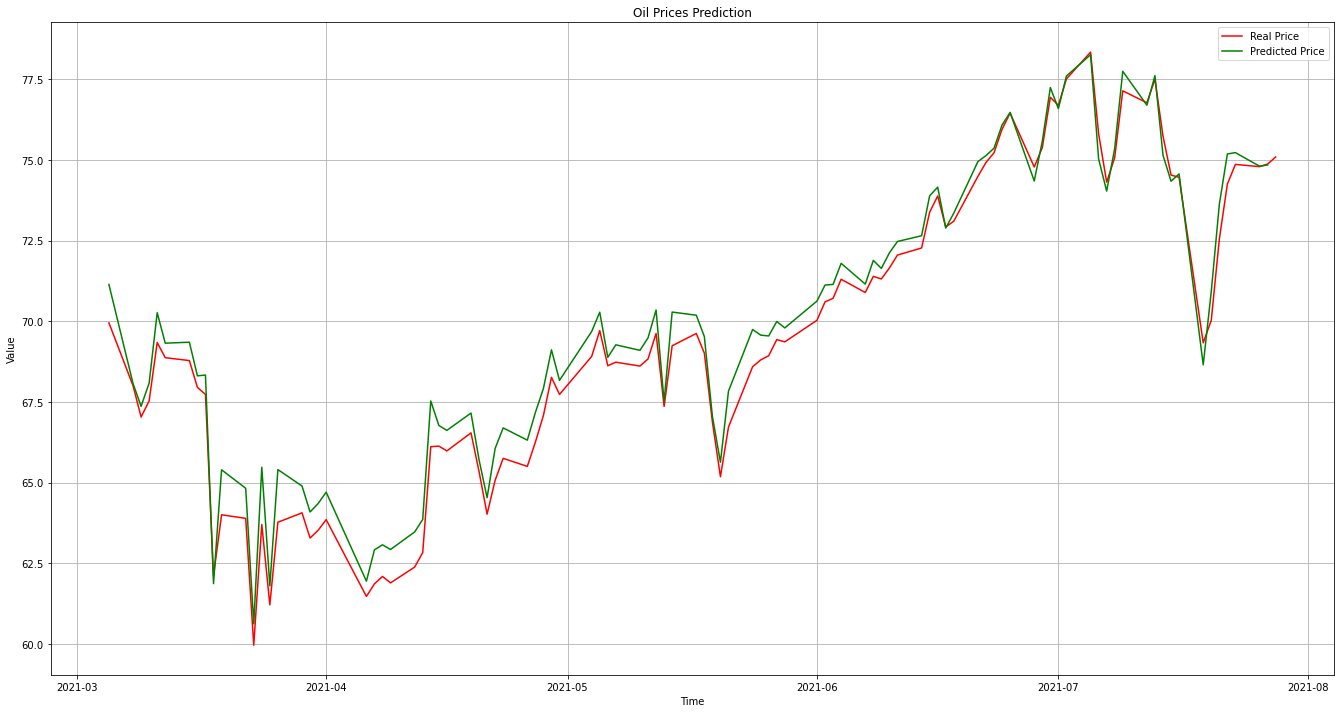

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Prediction')
plot_series(data_oil.index, data_oil.prices, start = upper_train+timesteps+len(y_test)-100, end = upper_train+timesteps+len(y_test), label = 'Real Price')
plot_series(data_oil.index[upper_train+timesteps+len(y_test)-100:upper_train+timesteps+len(y_test)-1], y_test[-99:].astype(float), color = 'green', label = 'Predicted Price')

In [ ]:
tf.keras.backend.clear_session()

# LSTM + Convolution

### Подготовим данные

In [ ]:
series = data_oil.iloc[:,0:1].values
series = np.squeeze(series)
series = tf.convert_to_tensor(series, dtype=tf.float32)

length = series.shape[0]
series.shape

TensorShape([8201])

In [ ]:
time = data_oil.index

In [ ]:
split_time = 6000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

### Построим модель

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


### Натренируем нейронную сеть и найдем оптимальное значение learning rate

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
47/47 [==============================] - 10s 215ms/step - loss: 63.6061 - mae: 63.8329
Epoch 2/100
47/47 [==============================] - 5s 110ms/step - loss: 56.1674 - mae: 57.0575
Epoch 3/100
47/47 [==============================] - 5s 108ms/step - loss: 46.6193 - mae: 47.4080
Epoch 4/100
47/47 [==============================] - 5s 106ms/step - loss: 39.8261 - mae: 40.6362
Epoch 5/100
47/47 [==============================] - 5s 109ms/step - loss: 37.9595 - mae: 38.7616
Epoch 6/100
47/47 [==============================] - 5s 110ms/step - loss: 35.9002 - mae: 36.7130
Epoch 7/100
47/47 [==============================] - 5s 112ms/step - loss: 33.6785 - mae: 34.3677
Epoch 8/100
47/47 [==============================] - 5s 105ms/step - loss: 30.8499 - mae: 31.5574
Epoch 9/100
47/47 [==============================] - 5s 108ms/step - loss: 28.2164 - mae: 28.9181
Epoch 10/100
47/47 [==============================] - 5s 108ms/step - loss: 25.8070 - mae: 26.4826
Epoch 11/100
47/47

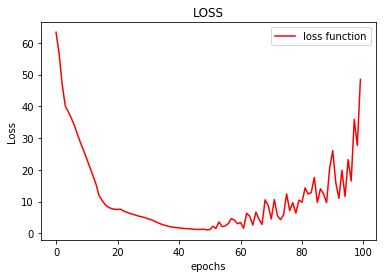

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'loss function')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('Loss')
# plt.xticks([data.index[upper_train], data.index[upper_train+75], data.index[upper_train+150], data.index[upper_train+225]])
plt.legend()
plt.show()

[1e-08, 0.0001, 0, 30]

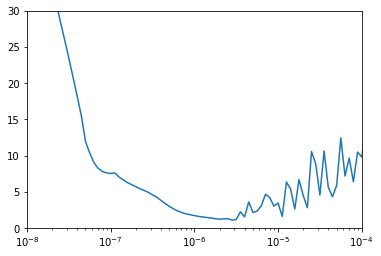

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### Повторим обучение с подобранным learning rate

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=5*1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
47/47 [==============================] - 10s 217ms/step - loss: 10.8578 - mae: 11.3726
Epoch 2/500
47/47 [==============================] - 5s 109ms/step - loss: 3.8715 - mae: 4.3469
Epoch 3/500
47/47 [==============================] - 5s 110ms/step - loss: 2.5978 - mae: 3.0638
Epoch 4/500
47/47 [==============================] - 5s 111ms/step - loss: 2.7894 - mae: 3.2579
Epoch 5/500
47/47 [==============================] - 5s 109ms/step - loss: 1.7410 - mae: 2.1922
Epoch 6/500
47/47 [==============================] - 5s 107ms/step - loss: 1.5131 - mae: 1.9570
Epoch 7/500
47/47 [==============================] - 5s 106ms/step - loss: 1.1263 - mae: 1.5606
Epoch 8/500
47/47 [==============================] - 5s 105ms/step - loss: 1.0563 - mae: 1.4883
Epoch 9/500
47/47 [==============================] - 5s 107ms/step - loss: 1.9361 - mae: 2.4392
Epoch 10/500
47/47 [==============================] - 5s 106ms/step - loss: 3.0145 - mae: 3.4844
Epoch 11/500
47/47 [================

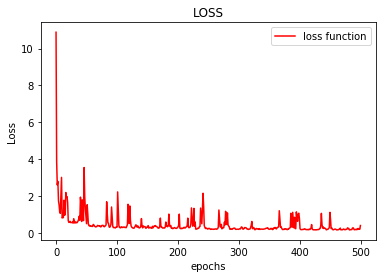

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'loss function')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('Loss')
# plt.xticks([data.index[upper_train], data.index[upper_train+75], data.index[upper_train+150], data.index[upper_train+225]])
plt.legend()
plt.show()

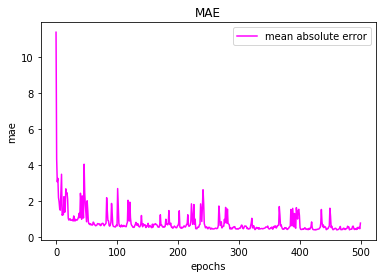

In [ ]:
plt.plot(history.history['mae'], color = 'magenta', label = 'mean absolute error')
plt.title('MAE')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

### Попробуем улучшить модель изменяя значение learning rate в течении обучения

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 5e-6 * 10**(-epoch / 100))
optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=300, callbacks=[lr_schedule])

Epoch 1/300
47/47 [==============================] - 10s 216ms/step - loss: 10.8578 - mae: 11.3726
Epoch 2/300
47/47 [==============================] - 5s 107ms/step - loss: 3.8688 - mae: 4.3450
Epoch 3/300
47/47 [==============================] - 5s 105ms/step - loss: 2.6249 - mae: 3.0937
Epoch 4/300
47/47 [==============================] - 5s 106ms/step - loss: 2.6831 - mae: 3.1524
Epoch 5/300
47/47 [==============================] - 5s 109ms/step - loss: 1.2433 - mae: 1.6645
Epoch 6/300
47/47 [==============================] - 5s 109ms/step - loss: 1.0336 - mae: 1.4499
Epoch 7/300
47/47 [==============================] - 5s 107ms/step - loss: 1.0568 - mae: 1.4816
Epoch 8/300
47/47 [==============================] - 5s 105ms/step - loss: 0.9069 - mae: 1.3211
Epoch 9/300
47/47 [==============================] - 5s 108ms/step - loss: 0.8678 - mae: 1.2863
Epoch 10/300
47/47 [==============================] - 5s 109ms/step - loss: 0.8178 - mae: 1.2176
Epoch 11/300
47/47 [================

In [ ]:
model.save("complex_model.h5")

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("complex_model.h5")

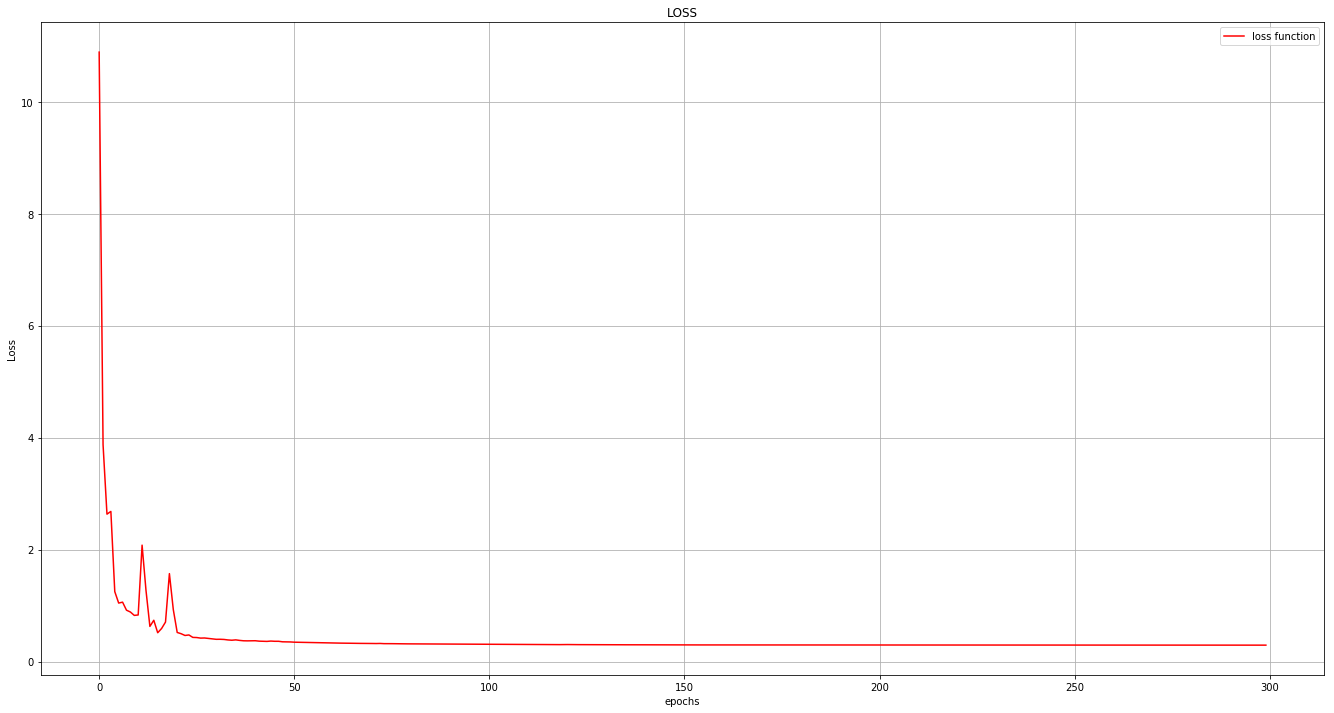

In [ ]:
plt.figure(figsize=(23,12))
plt.plot(history.history['loss'], color = 'red', label = 'loss function')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


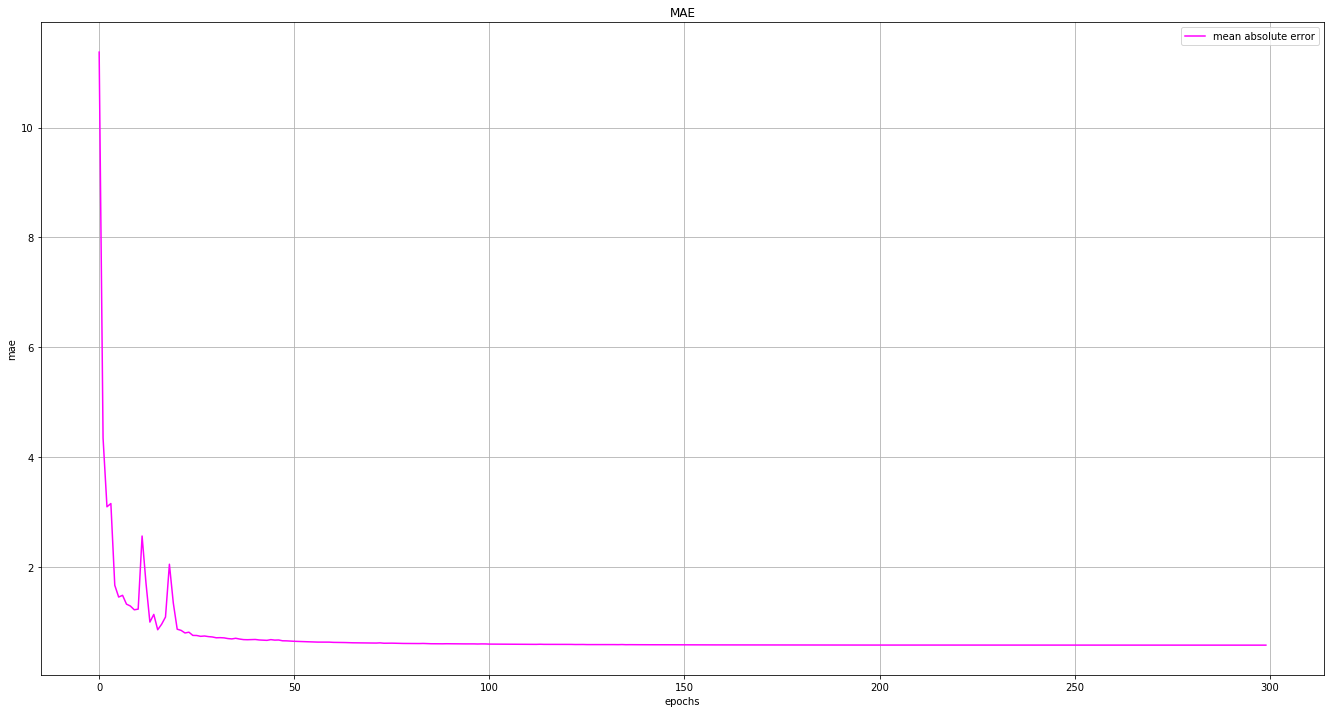

In [ ]:
plt.figure(figsize=(23,12))
plt.plot(history.history['mae'], color = 'magenta', label = 'mean absolute error')
plt.title('MAE')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.grid(True)
plt.legend()
plt.show()

### Прогнозирования модели и визуализация результата

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
complex_forecast = model_forecast(model, series[..., np.newaxis], window_size)
complex_forecast = complex_forecast[split_time - window_size:-1, -1, 0]

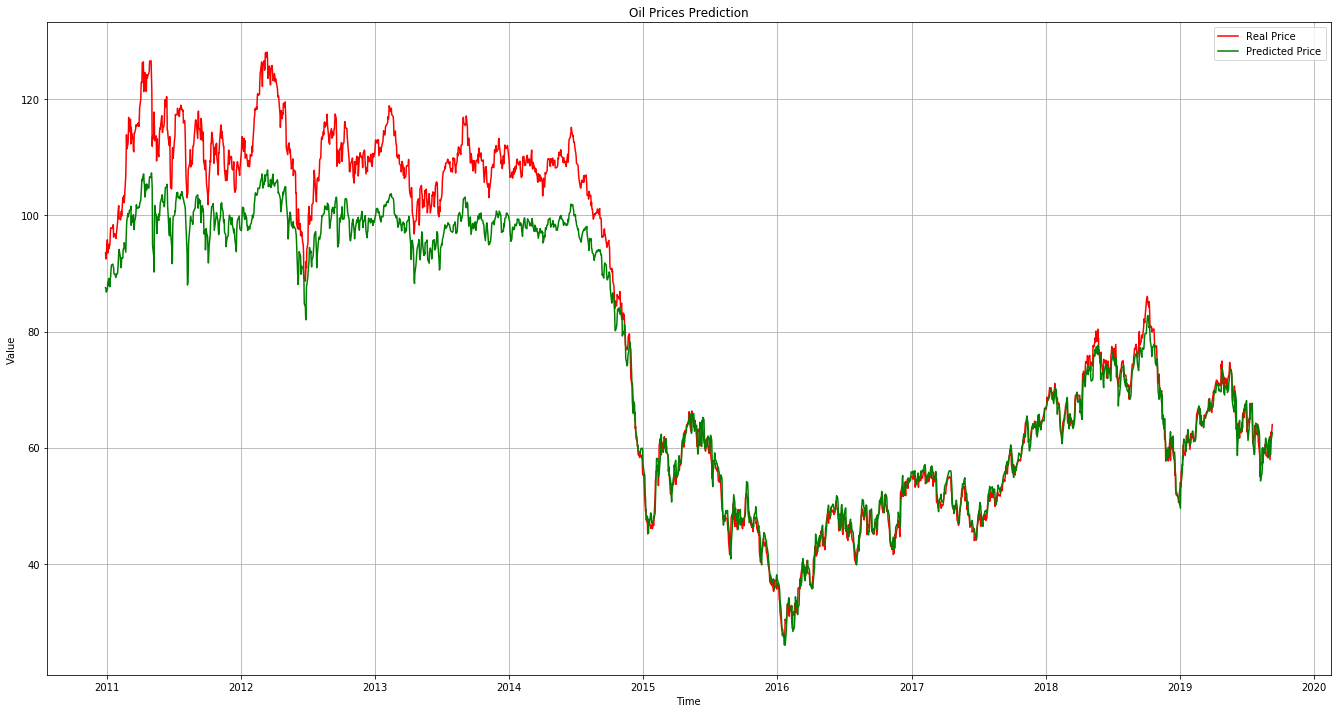

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Prediction')
plot_series(time_valid, x_valid, label = 'Real Price')
plot_series(time_valid, complex_forecast, color = 'green', label = 'Predicted Price')

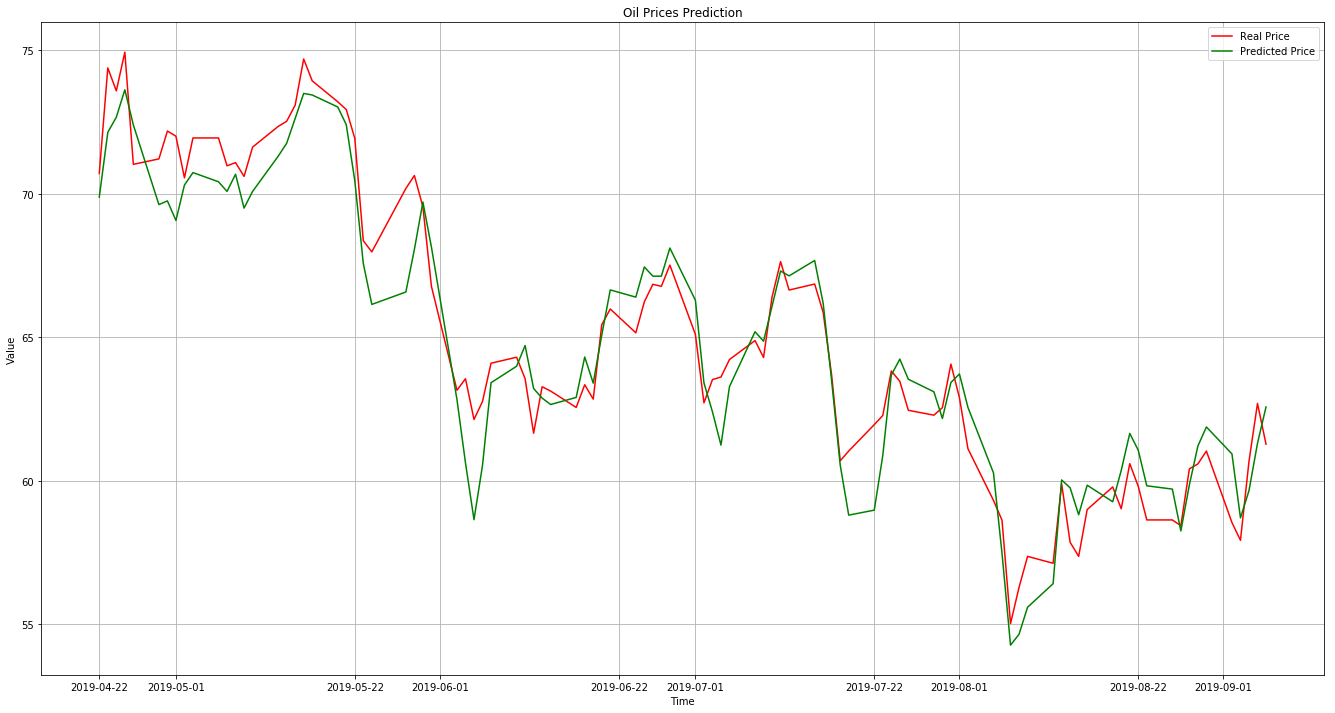

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Prediction')
plot_series(time_valid, x_valid, start = len(x_valid)-100, end = -1, label = 'Real Price')
plot_series(time_valid[len(x_valid)-100:-1], complex_forecast[len(x_valid)-99:], color = 'green', label = 'Predicted Price')

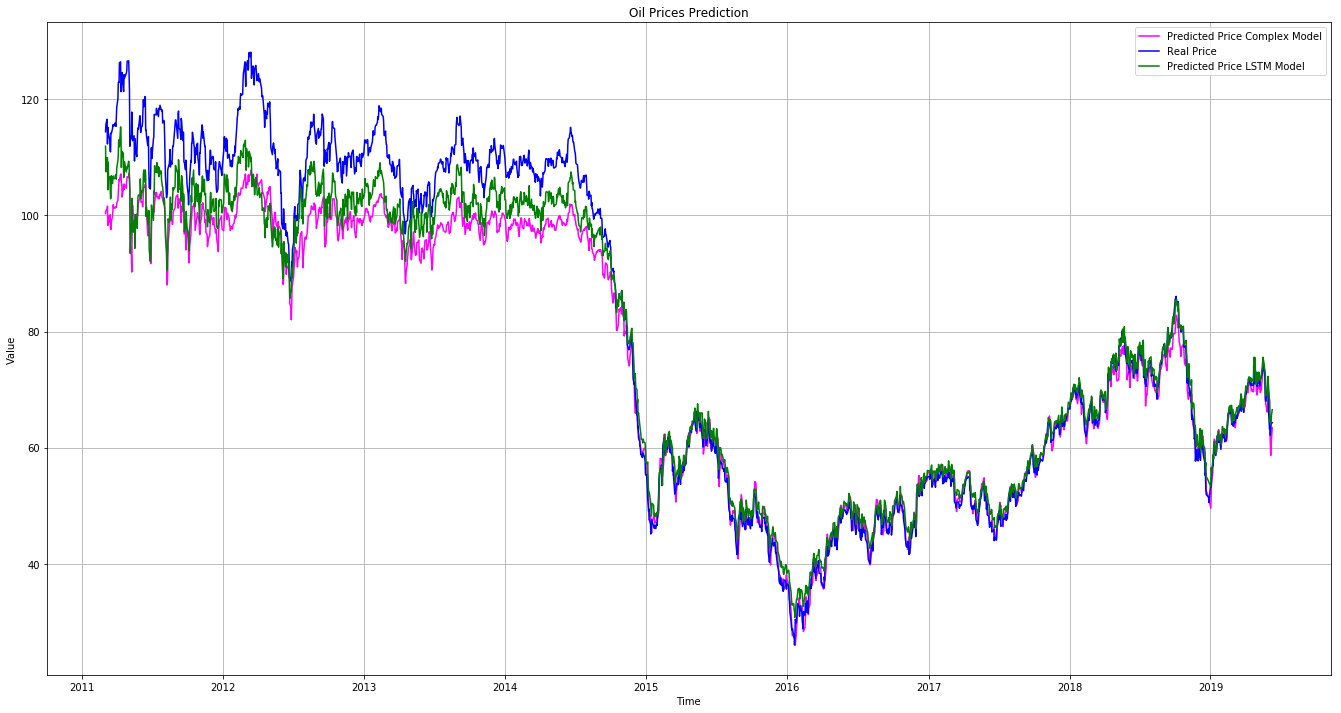

In [ ]:
plt.figure(figsize=(23,12))
plt.title('Oil Prices Prediction')
# plot_series(time_valid, x_valid, label = 'Real Price')
plot_series(time_valid, complex_forecast, start = upper_train+timesteps - 6000, end = upper_train+timesteps+len(y_test) - 6000, color = 'magenta', label = 'Predicted Price Complex Model')
plot_series(data_oil.index, data_oil.prices, start = upper_train+timesteps, end = upper_train+timesteps+len(y_test), color = 'blue', label = 'Real Price')
plot_series(data_oil.index[upper_train+timesteps:upper_train+timesteps+len(y_test)], y_test.astype(float), color = 'green', label = 'Predicted Price LSTM Model')